# IELTS Essay Scoring Model Evaluation

This notebook evaluates and calibrates our IELTS essay scoring model, analysing its performance and generating insights for the research paper.

## Key Objectives:
1. Calibrate model predictions to valid IELTS band range (0-9)
2. Calculate model accuracy metrics (MAE, R²)
3. Visualise prediction performance

/home/mastermind/ielts_pred/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading model from: /home/mastermind/ielts_pred/src/model/ielts_improved_model.pt

Loading model checkpoint...

 Model hyperparameters:
  Vocab size: 4000
  Embedding dim: 300
  Num layers: 3
✓ Model loaded successfully
✓ Best validation MAE from training: 0.0958

LOADING DATA
Total samples: 8985
Score distribution:
Overall
4.0    1047
4.5     595
5.0     954
5.5     875
6.0    1038
6.5    1058
7.0    1241
7.5    1031
8.0     652
8.5     394
9.0     100
Name: count, dtype: int64

Train set: 7637 samples
Test set:  1348 samples

EVALUATING ON TRAIN SET


Evaluating Train: 100%|██████████| 239/239 [00:42<00:00,  5.58it/s]



📊 Train Metrics:
  MAE:           1.155 bands
  R²:            -0.079
  Pearson r:     0.245
  Spearman ρ:    0.235
  ±0.5 Accuracy: 25.8%
  ±1.0 Accuracy: 49.4%

EVALUATING ON TEST SET


Evaluating Test: 100%|██████████| 43/43 [00:07<00:00,  5.78it/s]



📊 Test Metrics:
  MAE:           1.161 bands
  R²:            -0.077
  Pearson r:     0.260
  Spearman ρ:    0.243
  ±0.5 Accuracy: 24.6%
  ±1.0 Accuracy: 48.0%

OVERFITTING ANALYSIS

Train MAE: 1.155
Test MAE:  1.161
Gap:       -0.005 bands
✅ Good generalization (gap < 0.15 bands)

R² comparison:
  Train R²: -0.079
  Test R²:  -0.077

✓ Saved: evaluation_distributions.png


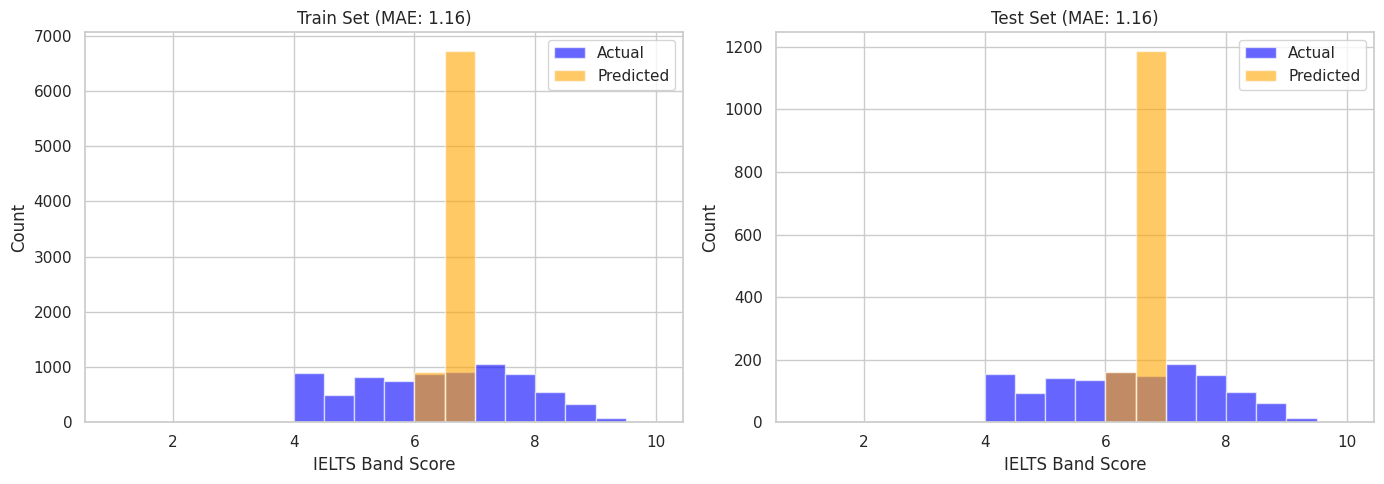

✓ Saved: evaluation_scatter.png


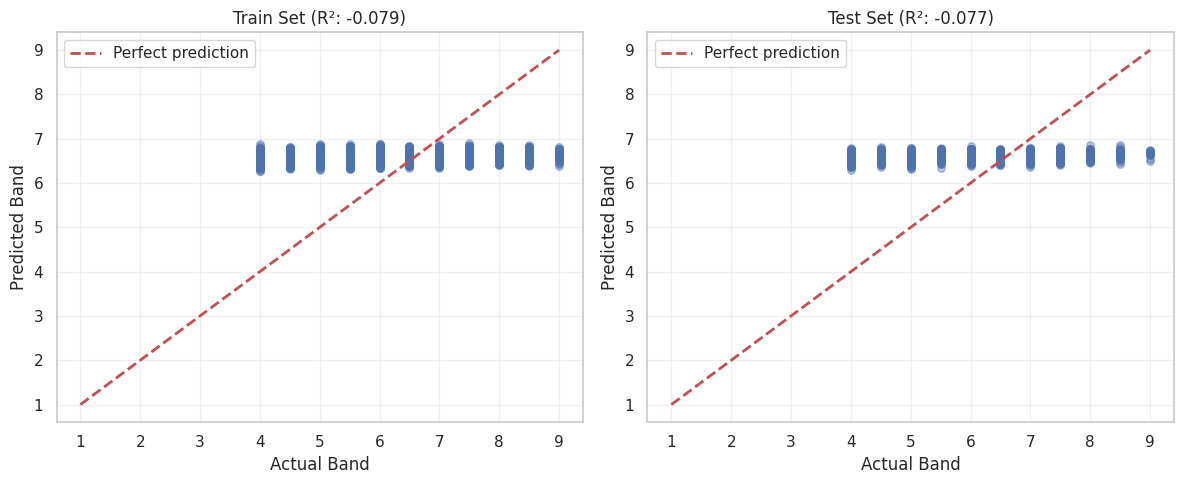

✓ Saved: evaluation_residuals.png


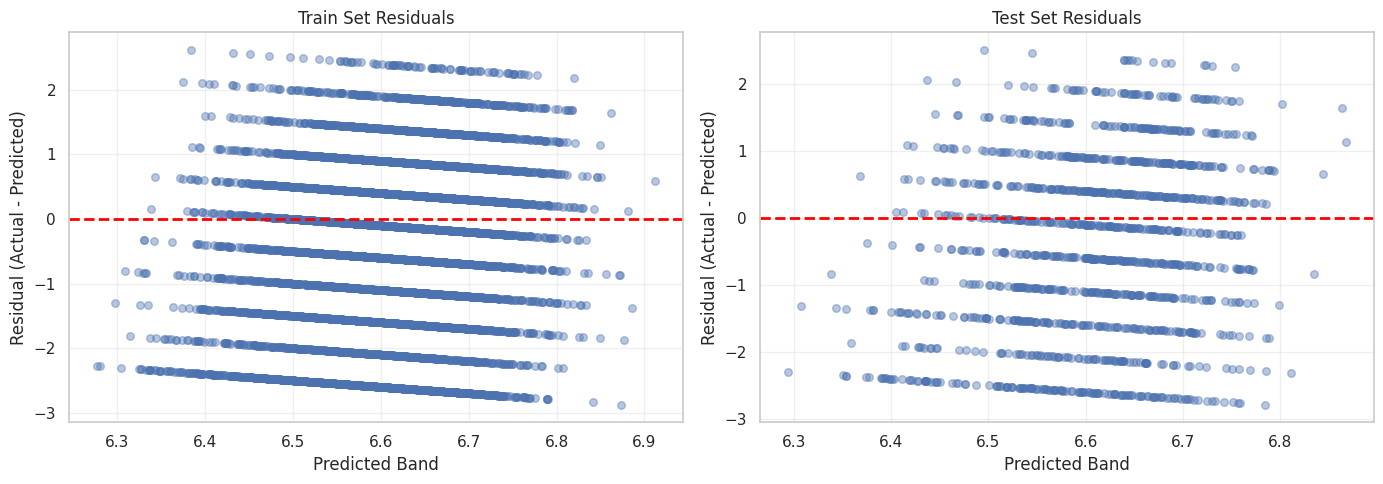

✓ Saved: evaluation_confusion.png


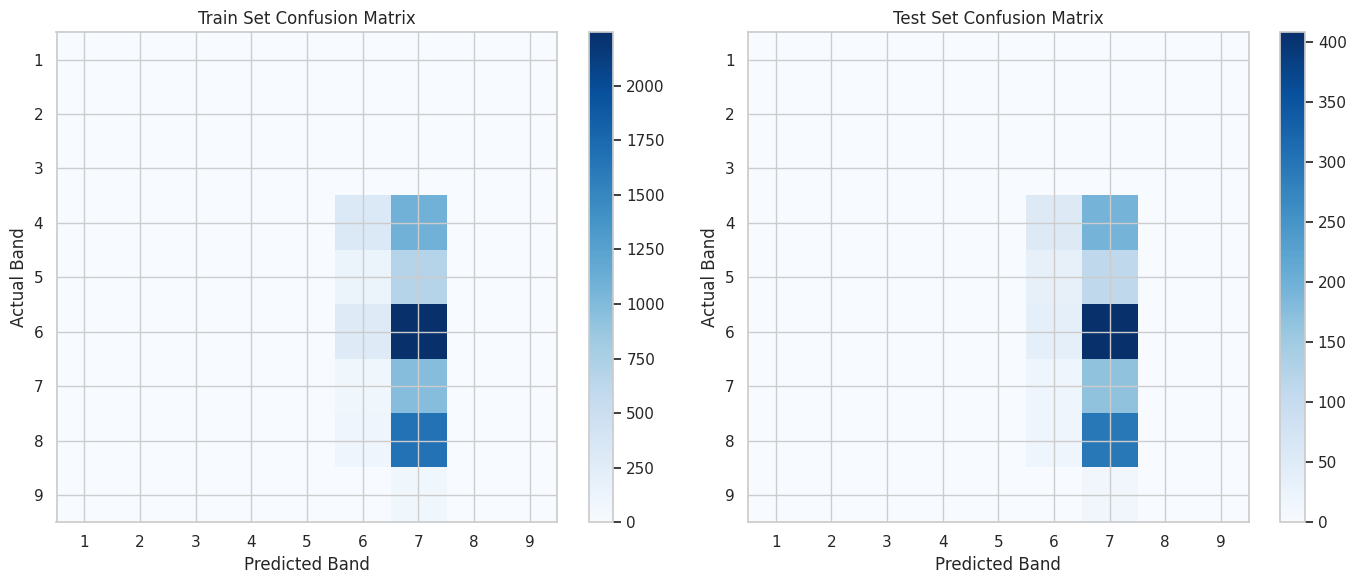


EVALUATION SUMMARY

📈 Performance Comparison:
Metric                      Train         Test          Gap
------------------------------------------------------------
MAE (bands)                 1.155        1.161       -0.005
R²                         -0.079       -0.077       -0.002
±0.5 Accuracy              25.8%       24.6%        1.3%
±1.0 Accuracy              49.4%       48.0%        1.4%

✓ Evaluation complete!


In [1]:
import os
import re
import numpy as np
import pandas as pd
import torch
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
from src.model.transformer import IELTSTransformerWithFeatures
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

project_root = "/home/mastermind/ielts_pred"
data_path = "data/predictions_hf_converted.csv"
model_checkpoint = os.path.join(project_root, "src/model/ielts_improved_model.pt")  
spm_model_path = os.path.join(project_root, "tokenizer/spm.model")
features_mean_path = os.path.join(project_root, "features_mean_fixed.npy")  
features_std_path = os.path.join(project_root, "features_std_fixed.npy")

MAX_SEQ_LEN = 200
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
print(f"Loading model from: {model_checkpoint}\n")

def extract_linguistic_features(essay):
    """Extract the same 10 features used in training."""
    words = essay.split()
    sentences = re.split(r'[.!?]+', essay)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    features = [
        len(words),
        len(sentences) if sentences else 1,
        len(words) / max(len(sentences), 1),
        len(set(w.lower() for w in words)) / max(len(words), 1),
        len(essay),
        sum(1 for c in essay if c.isupper()) / max(len(essay), 1),
        essay.count(',') / max(len(words), 1),
        essay.count('.') / max(len(sentences), 1),
        sum(len(w) for w in words) / max(len(words), 1),
        sum(1 for w in words if w.lower() in {
            'however', 'moreover', 'furthermore', 'therefore', 'consequently',
            'nevertheless', 'additionally', 'specifically', 'particularly'
        }) / max(len(words), 1)
    ]
    return np.array(features, dtype='float32')

sp = spm.SentencePieceProcessor(model_file=spm_model_path)
vocab_size = sp.get_piece_size()

def tokenize_essays(essays, max_len=MAX_SEQ_LEN):
    """Tokenize a batch of essays."""
    encoded, masks = [], []
    for e in essays:
        ids = sp.encode(e, out_type=int)[:max_len]
        mask = [1] * len(ids) + [0] * (max_len - len(ids))
        padded = ids + [0] * (max_len - len(ids))
        encoded.append(padded)
        masks.append(mask)
    return torch.tensor(encoded), torch.tensor(masks)



class IELTSDataset(Dataset):
    def __init__(self, essays, scores):
        self.essays = essays
        self.scores = scores
    
    def __len__(self):
        return len(self.essays)
    
    def __getitem__(self, idx):
        return self.essays[idx], self.scores[idx]


def create_collate_fn(feat_mean, feat_std):
    def collate_batch(batch):
        essays, scores = zip(*batch)
        
        # Tokenize
        X_tok, X_mask = tokenize_essays(essays)
        
        # Extract and normalize features
        features = np.array([extract_linguistic_features(e) for e in essays])
        features_norm = (features - feat_mean) / feat_std
        X_feat = torch.tensor(features_norm, dtype=torch.float32)
        
        y = torch.tensor(scores, dtype=torch.float32)
        
        return X_tok, X_mask, X_feat, y
    
    return collate_batch



print("Loading model checkpoint...")
checkpoint = torch.load(model_checkpoint, map_location=device)

vocab_size_ckpt = checkpoint.get('vocab_size', vocab_size)
embedding_dim = checkpoint.get('embedding_dim', 300)

state_dict = checkpoint['model_state_dict']

num_layers = sum(1 for k in state_dict.keys() if 'transformer.transformer_encoder.layers.' in k and '.linear1.weight' in k)
if num_layers == 0:
    num_layers = 3  

print(f"\n Model hyperparameters:")
print(f"  Vocab size: {vocab_size_ckpt}")
print(f"  Embedding dim: {embedding_dim}")
print(f"  Num layers: {num_layers}")

model = IELTSTransformerWithFeatures(
    vocab_size=vocab_size_ckpt,
    d_model=embedding_dim,
    nhead=6,
    num_layers=num_layers,
    max_len=MAX_SEQ_LEN,
    dropout=0.3,  # Doesn't matter for eval (dropout disabled)
    num_features=10
)

model.load_state_dict(state_dict)
model.to(device)
model.eval()

print(f"✓ Model loaded successfully")
print(f"✓ Best validation MAE from training: {checkpoint.get('best_val_mae', 'N/A'):.4f}\n")


# ============================================================================
# DATA LOADING & SPLITTING
# ============================================================================

print("="*70)
print("LOADING DATA")
print("="*70)

df = pd.read_csv(data_path)
df = df[['Essay', 'Overall']].dropna()
df = df[~df.duplicated(subset=['Essay'], keep='first')].reset_index(drop=True)

print(f"Total samples: {len(df)}")
print(f"Score distribution:\n{df['Overall'].value_counts().sort_index()}\n")

# ✅ CRITICAL: Split data the SAME way as training
# This gives you train vs test performance comparison
train_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,  # ✅ Same seed as training!
    stratify=df['Overall'].round()
)

print(f"Train set: {len(train_df)} samples")
print(f"Test set:  {len(test_df)} samples")


# ============================================================================
# EVALUATION FUNCTION
# ============================================================================

def evaluate_model(model, dataloader, split_name="Test"):
    """Evaluate model and return predictions + metrics."""
    print(f"\n{'='*70}")
    print(f"EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for X_tok, X_mask, X_feat, y in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            X_tok = X_tok.to(device)
            X_mask = X_mask.to(device)
            X_feat = X_feat.to(device)
            
            # Model outputs scaled predictions (0-1)
            pred_scaled = model(X_tok, X_feat, X_mask).squeeze()
            
            # Convert to IELTS bands (1-9)
            pred = (pred_scaled.cpu().numpy() * 9.0).clip(1, 9)
            
            all_preds.extend(pred)
            all_true.extend(y.numpy())
    
    y_pred = np.array(all_preds)
    y_true = np.array(all_true)
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pearson_r, _ = pearsonr(y_true, y_pred)
    spearman_rho, _ = spearmanr(y_true, y_pred)
    
    # Accuracy within thresholds
    within_05 = np.mean(np.abs(y_true - y_pred) <= 0.5)
    within_10 = np.mean(np.abs(y_true - y_pred) <= 1.0)
    
    print(f"\n📊 {split_name} Metrics:")
    print(f"  MAE:           {mae:.3f} bands")
    print(f"  R²:            {r2:.3f}")
    print(f"  Pearson r:     {pearson_r:.3f}")
    print(f"  Spearman ρ:    {spearman_rho:.3f}")
    print(f"  ±0.5 Accuracy: {within_05:.1%}")
    print(f"  ±1.0 Accuracy: {within_10:.1%}")
    
    return y_true, y_pred, {
        'mae': mae,
        'r2': r2,
        'pearson_r': pearson_r,
        'spearman_rho': spearman_rho,
        'within_05': within_05,
        'within_10': within_10
    }


# ============================================================================
# EVALUATE ON BOTH TRAIN AND TEST
# ============================================================================

# Load feature normalization stats
feat_mean = np.load(features_mean_path)
feat_std = np.load(features_std_path)

collate_fn = create_collate_fn(feat_mean, feat_std)

# Create dataloaders
train_dataset = IELTSDataset(train_df['Essay'].values, train_df['Overall'].values)
test_dataset = IELTSDataset(test_df['Essay'].values, test_df['Overall'].values)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Evaluate
train_true, train_pred, train_metrics = evaluate_model(model, train_loader, "Train")
test_true, test_pred, test_metrics = evaluate_model(model, test_loader, "Test")


# ============================================================================
# OVERFITTING CHECK
# ============================================================================

print("\n" + "="*70)
print("OVERFITTING ANALYSIS")
print("="*70)

train_test_gap = train_metrics['mae'] - test_metrics['mae']

print(f"\nTrain MAE: {train_metrics['mae']:.3f}")
print(f"Test MAE:  {test_metrics['mae']:.3f}")
print(f"Gap:       {train_test_gap:.3f} bands")

if abs(train_test_gap) < 0.15:
    print("✅ Good generalization (gap < 0.15 bands)")
elif abs(train_test_gap) < 0.3:
    print("⚠️  Moderate overfitting (gap 0.15-0.3 bands)")
else:
    print("❌ Significant overfitting (gap > 0.3 bands)")

print(f"\nR² comparison:")
print(f"  Train R²: {train_metrics['r2']:.3f}")
print(f"  Test R²:  {test_metrics['r2']:.3f}")


# ============================================================================
# VISUALIZATIONS
# ============================================================================

sns.set(style="whitegrid")

# 1. Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].hist(train_true, bins=np.arange(1, 10.5, 0.5), alpha=0.6, label='Actual', color='blue')
axes[0].hist(train_pred, bins=np.arange(1, 10.5, 0.5), alpha=0.6, label='Predicted', color='orange')
axes[0].set_xlabel("IELTS Band Score")
axes[0].set_ylabel("Count")
axes[0].set_title(f"Train Set (MAE: {train_metrics['mae']:.2f})")
axes[0].legend()

# Test
axes[1].hist(test_true, bins=np.arange(1, 10.5, 0.5), alpha=0.6, label='Actual', color='blue')
axes[1].hist(test_pred, bins=np.arange(1, 10.5, 0.5), alpha=0.6, label='Predicted', color='orange')
axes[1].set_xlabel("IELTS Band Score")
axes[1].set_ylabel("Count")
axes[1].set_title(f"Test Set (MAE: {test_metrics['mae']:.2f})")
axes[1].legend()

plt.tight_layout()
plt.savefig('evaluation_distributions.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved: evaluation_distributions.png")
plt.show()


# 2. Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train
axes[0].scatter(train_true, train_pred, alpha=0.4, s=30)
axes[0].plot([1, 9], [1, 9], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel("Actual Band")
axes[0].set_ylabel("Predicted Band")
axes[0].set_title(f"Train Set (R²: {train_metrics['r2']:.3f})")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test
axes[1].scatter(test_true, test_pred, alpha=0.4, s=30)
axes[1].plot([1, 9], [1, 9], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel("Actual Band")
axes[1].set_ylabel("Predicted Band")
axes[1].set_title(f"Test Set (R²: {test_metrics['r2']:.3f})")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_scatter.png', dpi=150, bbox_inches='tight')
print("✓ Saved: evaluation_scatter.png")
plt.show()


# 3. Residuals Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_residuals = train_true - train_pred
test_residuals = test_true - test_pred

# Train residuals
axes[0].scatter(train_pred, train_residuals, alpha=0.4, s=30)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel("Predicted Band")
axes[0].set_ylabel("Residual (Actual - Predicted)")
axes[0].set_title("Train Set Residuals")
axes[0].grid(alpha=0.3)

# Test residuals
axes[1].scatter(test_pred, test_residuals, alpha=0.4, s=30)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel("Predicted Band")
axes[1].set_ylabel("Residual (Actual - Predicted)")
axes[1].set_title("Test Set Residuals")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_residuals.png', dpi=150, bbox_inches='tight')
print("✓ Saved: evaluation_residuals.png")
plt.show()


# 4. Confusion Matrices (Rounded)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

train_true_rounded = np.rint(train_true).astype(int)
train_pred_rounded = np.rint(train_pred).astype(int)
test_true_rounded = np.rint(test_true).astype(int)
test_pred_rounded = np.rint(test_pred).astype(int)

cm_train = confusion_matrix(train_true_rounded, train_pred_rounded, labels=np.arange(1, 10))
cm_test = confusion_matrix(test_true_rounded, test_pred_rounded, labels=np.arange(1, 10))

# Train
im1 = axes[0].imshow(cm_train, cmap='Blues', aspect='auto')
axes[0].set_xlabel("Predicted Band")
axes[0].set_ylabel("Actual Band")
axes[0].set_title("Train Set Confusion Matrix")
axes[0].set_xticks(range(9))
axes[0].set_yticks(range(9))
axes[0].set_xticklabels(range(1, 10))
axes[0].set_yticklabels(range(1, 10))
plt.colorbar(im1, ax=axes[0])

# Test
im2 = axes[1].imshow(cm_test, cmap='Blues', aspect='auto')
axes[1].set_xlabel("Predicted Band")
axes[1].set_ylabel("Actual Band")
axes[1].set_title("Test Set Confusion Matrix")
axes[1].set_xticks(range(9))
axes[1].set_yticks(range(9))
axes[1].set_xticklabels(range(1, 10))
axes[1].set_yticklabels(range(1, 10))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig('evaluation_confusion.png', dpi=150, bbox_inches='tight')
print("✓ Saved: evaluation_confusion.png")
plt.show()


# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)

print("\n📈 Performance Comparison:")
print(f"{'Metric':<20} {'Train':>12} {'Test':>12} {'Gap':>12}")
print("-" * 60)
print(f"{'MAE (bands)':<20} {train_metrics['mae']:>12.3f} {test_metrics['mae']:>12.3f} {train_test_gap:>12.3f}")
print(f"{'R²':<20} {train_metrics['r2']:>12.3f} {test_metrics['r2']:>12.3f} {train_metrics['r2']-test_metrics['r2']:>12.3f}")
print(f"{'±0.5 Accuracy':<20} {train_metrics['within_05']:>11.1%} {test_metrics['within_05']:>11.1%} {train_metrics['within_05']-test_metrics['within_05']:>11.1%}")
print(f"{'±1.0 Accuracy':<20} {train_metrics['within_10']:>11.1%} {test_metrics['within_10']:>11.1%} {train_metrics['within_10']-test_metrics['within_10']:>11.1%}")

print("\n✓ Evaluation complete!")